In [1]:
from bokeh.models import ColumnDataSource, HoverTool, \
    LinearColorMapper, BasicTicker, ColorBar
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import datasets as kdatasets
import matplotlib.pyplot as plt
import numpy as np
import helper_methods

# I've decided to output the code into the notebook,
# for ease of illustration in this code sample.
output_notebook()

# Since we use tensorflow, CUDA would be helpful
# but since this is a sample it wont be necessary.
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

# Some functions that we will be using,
# the larger ones are in an external file.


def process_data(data):
    '''Returns the data in a format usable for the NN, normalized.
    The range is 0 - 255 because we know these are images.

    Parameters:
        data (numpy.ndarray):The string which is to be reversed.

    Returns:
        (numpy.ndarray): The input data normalized in the range [0,1]
    '''
    data = [np.array(x).flatten() for x in data]
    return np.array(data)/255.0


def nh_per_item(k, x_test, x_2d_test, y_test):
    ''' Computed the Neighborhood Hit per item in the input data.
     Neighborhood hit is a measure of the fraction of your neighbors
     that share your class label.
     Intuitively, similar points have the same label.

    Parameters:
        k (int): The number of neighbors to consider to evaluate
                 the proportion of labels shared.
        x_test (numpy.ndarray): The X values of input data
        x_2d_test (numpy.ndarray): The 2d coordinates of the predicted x values
        y_test (numpy.ndarray): The class labels of the data (unseen by NN)

    Returns:
        list_nh(list): A list containing the NH values for each sample.
    '''

    n = x_test.shape[0]
    list_nh = list()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_2d_test, y_test)
    neighbors = knn.kneighbors(x_2d_test, return_distance=False)
    for i in range(n):
        list_nh.append((metric_neighborhood_hit_local(y_test,
                                                      i,
                                                      neighbors)))
    return list_nh


def metric_neighborhood_hit_local(y, i, neighbors):
    '''Neighborhood hit computation at a local scale, as opposed to global
       (per point not over the whole set)

    Parameters:
        y (numpy.ndarray): An array of input values.
        i (int): The index of this particular point
        neighbors: The nearest neighbors as given by the classifier,
                   cheaper to compute globally in the above function.

    Returns:
        (numpy.float64): The input data normalized in the range [0,1]
    '''

    count = [1 if y[i] == n else 0 for n in y[neighbors[i]]]

    return np.mean(count)


Using TensorFlow backend.


Loading BokehJS ...

In [2]:
# Create a training set, preprocess the data and
# do necessary set-up to train the network.
train_size = 5000
test_size = 5000

(x_train, y_train), (x_test, y_test) = kdatasets.mnist.load_data()
processed_X_train = process_data(x_train[:train_size])
processed_X_test = process_data(x_test[:test_size])
y_test = y_test[:test_size].flatten()
y_train = y_train[:train_size].flatten()

# We use t-SNE to create the original mulitidimensional projection.
# Normally we want to use 4 cores (multi-core tsne) but this can be tricky 
# to implement across platforms so for simplicty we use the sklearn package.
p = TSNE(n_components=2, random_state=420, perplexity=25.0)
X_2d_train = helper_methods.project(processed_X_train, p)

# We train a shallow dense neural network on the training set
# and the projection.
# The output layer outputs coordinates as a prediction.
# Each layer is activated by Relu, output activation is a sigmoid.
# We use Adam optimiser to optimize MSE with early stopping.
# The y-true values for MSE are the projection coordinate for each x.
m, _ = helper_methods.train_model(processed_X_train, X_2d_train)

# Use the model we just created and trained to predict the training set
# and the test set.
X_pred_2d_train = m.predict(processed_X_train)
X_pred_2d_test = m.predict(processed_X_test)

Restoring model weights from the end of the best epoch
Epoch 00051: early stopping


Text(0.5, 1.0, 'NN on test set (unseen data)')

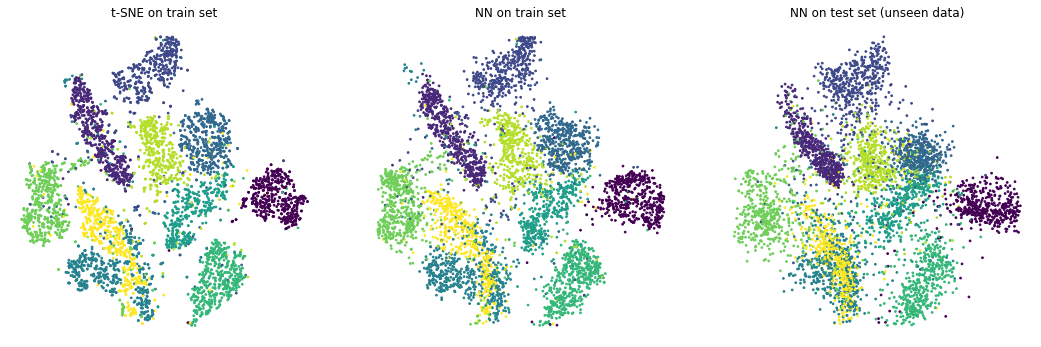

In [3]:
# We graph the projection against the neural network's learned projection
# on the training and test set (unseen) using matplotlib
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout()

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[0].scatter(X_2d_train[:, 0], X_2d_train[:, 1], c=y_train, s=3)
ax[0].set_title('t-SNE on train set')

ax[1].scatter(X_pred_2d_train[:, 0], X_pred_2d_train[:, 1], c=y_train, s=3)
ax[1].set_title('NN on train set')

ax[2].scatter(X_pred_2d_test[:, 0], X_pred_2d_test[:, 1], c=y_test, s=3)
ax[2].set_title('NN on test set (unseen data)')

In [4]:
# Aside from matplotlib, I think the interactivity offered by Bokeh
# is useful for data exploration.
# We are going to choose to evaluate the neighborhoods
# that the neural network learned to test the inter-point dependencies.
# We do this because we are interested in the identity of points,
# rather than the accuracy as in MSE.

neighbors = nh_per_item(7, processed_X_test, X_pred_2d_test, y_test)

metric_mapper = LinearColorMapper(palette="Magma256", low=0, high=1)
source = ColumnDataSource(data=dict(x=X_pred_2d_test[:, 0],
                                    y=X_pred_2d_test[:, 1],
                                    metric=neighbors,
                                    label=y_test,
                                    index=range(0, test_size)))
p = figure(width=800, height=800,
           title='Predicted Testing samples, colored darker when clustered'
           + ' with different classes',
           tools="")

# Here we add a little bit of html to customize the Bokeh hover tool,
# this allows the user to interact with the graph (mouse hover).
hover_selection = HoverTool(tooltips='''
                                <span>Index of sample:
                                <b>@index</b></span></br>
                                <span>Class label:
                                <b>@label</b></span></br>
                                <span>Proportion of neighbors
                                with same label:
                                <b>@metric </b></span></br>
                                ''')

color_bar = ColorBar(color_mapper=metric_mapper,
                     ticker=BasicTicker(),
                     location=(0, 0))
p.circle('x', 'y', source=source,
         color={'field': 'metric',
                'transform': metric_mapper},
         fill_alpha=1,
         size=5)
p.add_layout(color_bar, 'right')
p.add_tools(hover_selection)
p.axis.visible = False
p.grid.grid_line_color = None
show(p)